In [1]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
using Random, Distributions, Statistics, DataFrames, VegaLite, Plots
Random.seed!(10)

TaskLocalRNG()

In [3]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.75, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels)
end

simulateOneRun (generic function with 1 method)

In [5]:
function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 2 methods)

In [6]:
using Random
Random.seed!(10)
df = DataFrame(run_sims(30,s,S,1000)
    for S in 100:100:1000, s in 20:10:50 if S > s )
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
12,30,30,200,1000,1275.55,115.325,7.246,13.9784


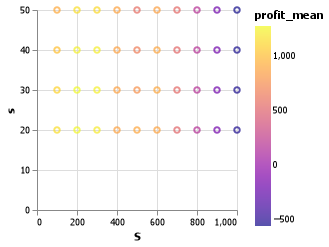

In [7]:
#using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

In [8]:
# using Random
Random.seed!(10)
df = DataFrame(run_sims(30,s,S,1000)
    for S in 100:10:350, s in 10:5:50 if S > s )
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
61,30,20,180,1000,1308.8,106.534,14.089,18.2738


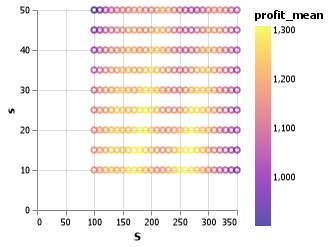

In [9]:
# We can observe that there are more good points where we have high profit_mean values.
using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

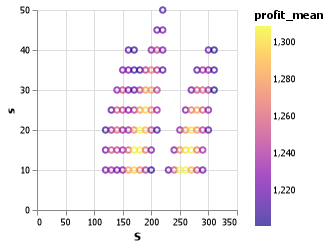

In [10]:
# We check those values that have profit_mean values over 1200.
filtered_df_1200 = filter(row -> row.profit_mean >= 1200, df)
using VegaLite
filtered_df_1200 |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

We can observe our maximum profit_mean=1308 for the parameters s=20 and S=180, but we also have some other equally good values. So let us check the other points

In [11]:
filtered_df = filter(row -> row.s == 15 && row.S == 270, df)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,15,270,1000,1305.82,126.717,13.069,16.7615


In [12]:
filtered_df = filter(row -> row.s == 10 && row.S == 250, df)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,10,250,1000,1306.99,120.282,21.379,19.5673


We can see that the values s=15 and S=270 generate us a profit_mean=1305 less lost_mean=13.06, which could be our 2nd choice.  <br />
If we choose a slightly smaller profit_mean, we will also have a smaller lost_mean, which also seems to be a good result.

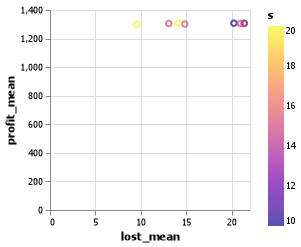

In [13]:
using VegaLite
filtered_df_1300 = filter(row -> row.profit_mean >= 1300, df)
filtered_df_1300 |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

In [14]:
sort!(filtered_df_1300, :lost_mean)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,20,270,1000,1300.49,123.039,9.54,14.9159
2,30,15,270,1000,1305.82,126.717,13.069,16.7615
3,30,20,180,1000,1308.8,106.534,14.089,18.2738
4,30,15,260,1000,1301.73,122.841,14.833,17.4992
5,30,10,260,1000,1307.82,126.708,20.225,19.7092
6,30,15,180,1000,1305.66,125.596,20.943,21.1076
7,30,15,170,1000,1305.45,108.113,21.344,21.4889
8,30,10,250,1000,1306.99,120.282,21.379,19.5673


In the table above, we can see all the best results.  

In [15]:
zysk  = (1308.8 - 1275.55) * 12
print("Average annual profit = ",zysk)

Average annual profit = 399.0

In [16]:
procent = (399 / (1275.55 * 12)) * 100
procent = round(procent, digits=2)
print("Average annual percentage of profit = ", procent, "%")

Average annual percentage of profit = 2.61%

Conduct a Sensitivity Analysis: parameter change vs. the optimal solution (RO)
- Will a change in a parameter (e.g. increase in product price by 5%/increase in hourly wages ) result in a change in the R.O. or will it still remain the same?


In [17]:
Random.seed!(10)
using Random
using Distributions
using Statistics

function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.75, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h
        lost_orders += lost_order
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels)
end

simulateOneRun (generic function with 1 method)

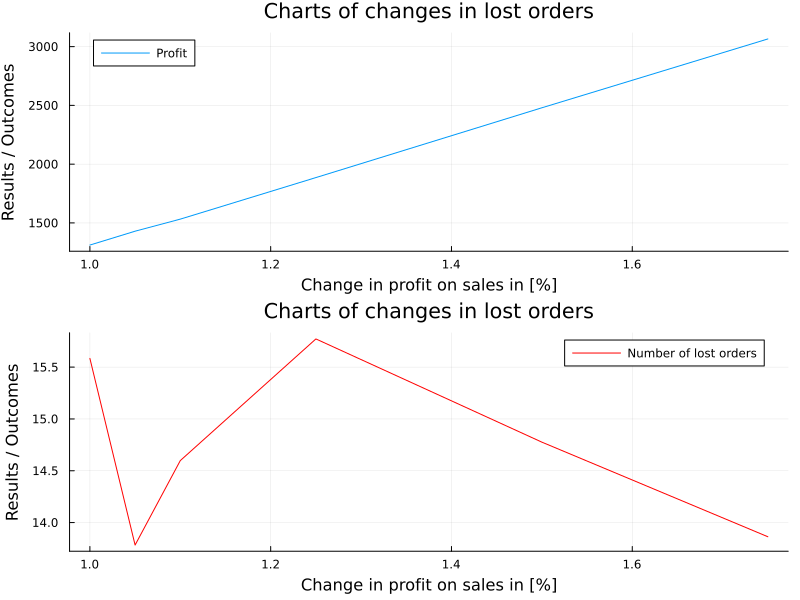

In [18]:
using Plots
Plots.gr(size=(800, 600))
Random.seed!(10)
m = 30
s = 20
S = 180
h = 0.1
c = 4.0
p = 0.75
K = 100
k = 1.0
init_S = 100
average_demand = 20

profit_mean = zeros(Float64, 6)
lost_mean = zeros(Float64, 6)

for (i, wage) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*wage, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profit_mean[i] = mean(results.profit)
    lost_mean[i] = mean(results.lost_orders)
end
pr = plot(layout = (2, 1))
plot!(pr[1],[1, 1.05, 1.1, 1.25, 1.5, 1.75], profit_mean, label="Profit")
xlabel!("Change in profit on sales in [%]")
ylabel!("Results / Outcomes")
title!("Charts of the change in profit in relation to the change in sales profit")
plot!(pr[2],[1, 1.05, 1.1, 1.25, 1.5, 1.75], lost_mean, label="Number of lost orders",linecolor = :red)
xlabel!("Change in profit on sales in [%]")
ylabel!("Results / Outcomes")
title!("Charts of changes in lost orders")

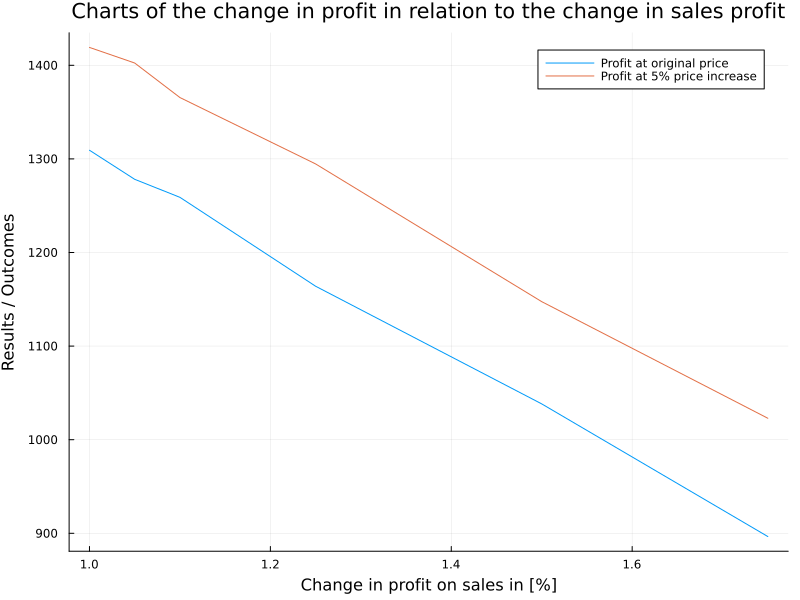

In [20]:
profits_payroll_change_1_00 = zeros(Float64, 6)
lost_orders_payroll_change_1_00 = zeros(Float64, 6)

for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_00[i] = mean(results.profit)
    lost_orders_payroll_change_1_00[i] = mean(results.lost_orders)
end

profits_payroll_change_1_05 = zeros(Float64, 6)
lost_orders_payroll_change_1_05 = zeros(Float64, 6)

for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.05, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_05[i] = mean(results.profit)
    lost_orders_payroll_change_1_05[i] = mean(results.lost_orders)
end

plot([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_00, label="Profit at original price")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_05, label="Profit at 5% price increase")
xlabel!("Change in profit on sales in [%]")
ylabel!("Results / Outcomes")
title!("Charts of the change in profit in relation to the change in sales profit")

In [22]:
Random.seed!(10)

profits_payroll_change_1_10 = zeros(Float64, 6)
lost_orders_payroll_change_1_10 = zeros(Float64, 6)
 
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.1, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_10[i] = mean(results.profit)
    lost_orders_payroll_change_1_10[i] = mean(results.lost_orders)
end

profits_payroll_change_1_20 = zeros(Float64, 6)
lost_orders_payroll_change_1_20 = zeros(Float64, 6)

for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.2, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_20[i] = mean(results.profit)
    lost_orders_payroll_change_1_20[i] = mean(results.lost_orders)
end

profits_payroll_change_1_50 = zeros(Float64, 6)
lost_orders_payroll_change_1_50 = zeros(Float64, 6)

for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.5, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_50[i] = mean(results.profit)
    lost_orders_payroll_change_1_50[i] = mean(results.lost_orders)
end

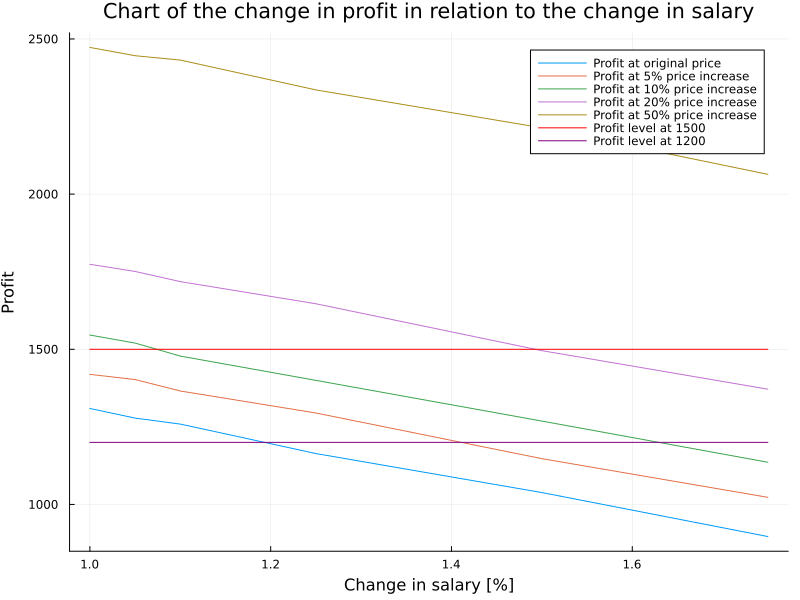

In [24]:
plot([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_00, label="Profit at original price")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_05, label="Profit at 5% price increase")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_10, label="Profit at 10% price increase")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_20, label="Profit at 20% price increase")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_50, label="Profit at 50% price increase")
plot!([1, 1.75], [1500, 1500], linecolor=:red, linewidth=1, label="Profit level at 1500")
plot!([1, 1.75], [1200, 1200], linecolor=:purple, linewidth=1, label="Profit level at 1200")
xlabel!("Change in salary [%]")
ylabel!("Profit")
title!("Chart of the change in profit in relation to the change in salary")

## Ceteris-paribus analysis for 3 parameters

In [25]:
h = 0.1 storage_cost
p = 0.75 prob_of_delivery

LoadError: syntax: extra token "storage_cost" after end of expression

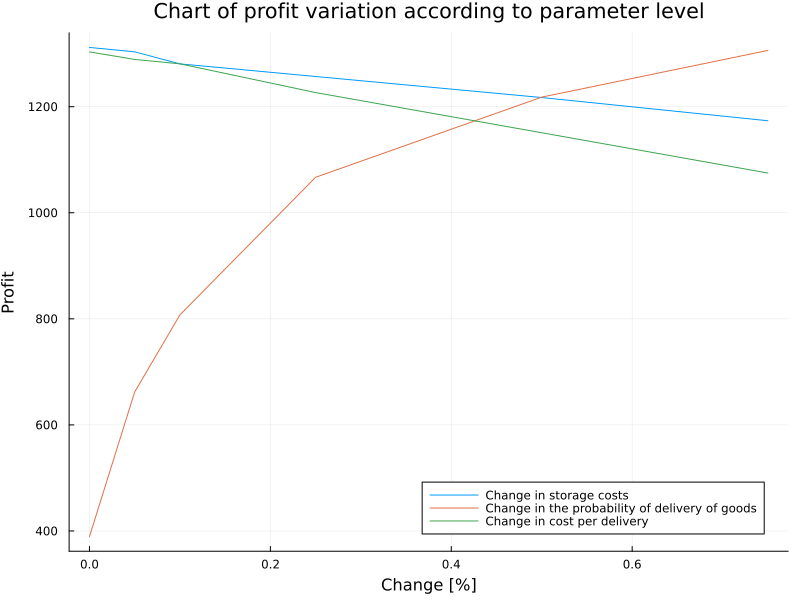

In [26]:
Random.seed!(10)
m = 30
s = 20
S = 180
h = 0.1
c = 4.0
p = 0.75
K = 100
k = 1.0
init_S = 100
average_demand = 20
storage_cost_change = zeros(Float64, 6)
prob_of_delivery_change = zeros(Float64, 6)
fixed_order_cost_change = zeros(Float64, 6)


for (i, storage_cost) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h*(storage_cost + 1), c=c, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    storage_cost_change[i] = mean(results.profit)
end

for (i, prob_of_delivery) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=prob_of_delivery, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    prob_of_delivery_change[i] = mean(results.profit)
end

for (i, fixed_order_cost) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=p, K=K*(1+fixed_order_cost), k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    fixed_order_cost_change[i] = mean(results.profit)
end



plot([0, 0.05, 0.1, 0.25, 0.5, 0.75], storage_cost_change, label="Change in storage costs")
plot!([0, 0.05, 0.1, 0.25, 0.5, 0.75], prob_of_delivery_change, label="Change in the probability of delivery of goods")
plot!([0, 0.05, 0.1, 0.25, 0.5, 0.75], fixed_order_cost_change, label="Change in cost per delivery")
title!("Chart of profit variation according to parameter level")
xlabel!("Change [%]")
ylabel!("Profit")

In [27]:
using DataFrames
Profit = storage_cost_change
koszt_przechowania_jednostki_towaru = [1, 1.05, 1.1, 1.25, 1.5, 1.75] .* 0.1
df = DataFrame(Profit = Profit, Koszt_przechowania_jednostki_towaru = koszt_przechowania_jednostki_towaru)

Row,Profit,Koszt_przechowania_jednostki_towaru
,Float64,Float64
1,1311.78,0.1
2,1303.41,0.105
3,1280.75,0.11
4,1256.9,0.125
5,1217.25,0.15
6,1173.51,0.175


In [28]:
using DataFrames
Profit = prob_of_delivery_change
Zmiana_pradopodobieństwa_dostawy = [0, 0.05, 0.1, 0.25, 0.5, 0.75]
df = DataFrame(Profit = Profit, Pradopodobieństwa_dostawy = Zmiana_pradopodobieństwa_dostawy)

Row,Profit,Pradopodobieństwa_dostawy
,Float64,Float64
1,389.446,0.0
2,662.208,0.05
3,807.51,0.1
4,1066.92,0.25
5,1218.09,0.5
6,1306.15,0.75


In [29]:
using DataFrames
Profit = fixed_order_cost_change
Zmiana_kosztow_dostawy = [1, 1.05, 1.1, 1.25, 1.5, 1.75] .* 100
df = DataFrame(Profit = Profit, Zmiana_kosztow_dostawy = Zmiana_kosztow_dostawy)

Row,Profit,Zmiana_kosztow_dostawy
,Float64,Float64
1,1303.32,100.0
2,1289.1,105.0
3,1280.83,110.0
4,1226.6,125.0
5,1150.85,150.0
6,1074.9,175.0
